# [How to apply LSTM using PyTorch](https://cnvrg.io/pytorch-lstm/) - Practical Implementation in PyTorch


In [149]:
import sys
import os
from os import path
import importlib

import numpy as np
np.set_printoptions(formatter={'float_kind':"{:-.3e}".format})
np.random.seed(0)

import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5, 4)

import torch
torch.manual_seed(0)

import torch.nn as nn
from torch.autograd import Variable

SRC_DIR = path.join(os.path.abspath(""), '../')
sys.path.append(SRC_DIR)

import core as co
from core import _
import hist_data as hd

In [151]:
hd.set_hist_data(data_count=None)

In [206]:
import nn_tools.data_sequencer as ds
importlib.reload(ds)

<module 'nn_tools.data_sequencer' from 'c:\\users\\stefa\\documents\\workspaces\\szx81\\szx81\\nn_tools\\data_sequencer.py'>

## NN Driver test begin

In [207]:
import nn_tools.lstm as ls
importlib.reload(ls)
dr = ls.NnDriver(
        data_source_class=ds.ForexDataSource,
        model_class=ls.Model,
        verbose=True
        )

In [208]:
print('NnDriver model:', dr.model)

NnDriver model: Model(
  (model): LSTM(10, 100, num_layers=3, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
)


begin index: 2880, end index: 3895, count:1000
Epoch [10/1000], Loss: 3.0e-01
Epoch [20/1000], Loss: 1.5e-01
Epoch [30/1000], Loss: 2.1e-02
Epoch [40/1000], Loss: 2.8e-03
Epoch [50/1000], Loss: 5.9e-03
Epoch [60/1000], Loss: 3.8e-03
Epoch [70/1000], Loss: 2.1e-03
Epoch [80/1000], Loss: 2.0e-03
Epoch [90/1000], Loss: 2.0e-03
Epoch [100/1000], Loss: 1.9e-03
Epoch [110/1000], Loss: 1.8e-03
Epoch [120/1000], Loss: 1.8e-03
Epoch [130/1000], Loss: 1.8e-03
Epoch [140/1000], Loss: 1.8e-03
Epoch [150/1000], Loss: 1.7e-03
Epoch [160/1000], Loss: 1.7e-03
Epoch [170/1000], Loss: 1.7e-03
Epoch [180/1000], Loss: 1.7e-03
Epoch [190/1000], Loss: 1.7e-03
Epoch [200/1000], Loss: 1.7e-03
Epoch [210/1000], Loss: 1.7e-03
Epoch [220/1000], Loss: 1.6e-03
Epoch [230/1000], Loss: 1.6e-03
Epoch [240/1000], Loss: 1.6e-03
Epoch [250/1000], Loss: 1.6e-03
Epoch [260/1000], Loss: 1.6e-03
Epoch [270/1000], Loss: 1.6e-03
Epoch [280/1000], Loss: 1.6e-03
Epoch [290/1000], Loss: 1.6e-03
Epoch [300/1000], Loss: 1.6e-03
Ep

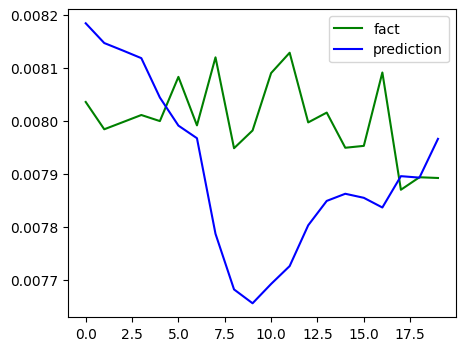

In [209]:
dr.train()
dr.show_action(shift=250)

In [211]:
cs_dr = dr.context_seq
print('end_index: ', cs_dr.last_trained_index)

end_index:  3895


In [204]:
x_dr, y_dr = dr.get_training(verbose=True)
print(f'last X_train:\n{x_dr[-1]}')
print(f'last y_train:\n{y_dr[-1]}')

begin index: 2880, end index: 2880, count:1000
last X_train:
[-6.368e-03 -6.387e-03 -6.396e-03 -6.290e-03 -6.305e-03 -6.209e-03
 -6.368e-03 -6.417e-03 -6.446e-03 -6.495e-03]
last y_train:
-0.006445748263888551


In [189]:
x_dr_pr, y_dr_pr = dr.preprocessor.pre(x_dr, y_dr)
print(x_dr_pr)
print(y_dr_pr)[0]

tensor([[[-0.4876, -0.4606, -0.4498,  ..., -0.4295, -0.4250, -0.4110]],

        [[-0.4636, -0.4523, -0.4491,  ..., -0.4255, -0.4112, -0.4300]],

        [[-0.4552, -0.4516, -0.4633,  ..., -0.4114, -0.4305, -0.3935]],

        ...,

        [[ 6.5627,  6.4800,  6.8401,  ...,  6.2420,  5.8048,  5.6950]],

        [[ 6.6326,  6.9924,  6.4570,  ...,  5.8990,  5.7850,  5.3784]],

        [[ 7.1564,  6.6011,  6.4272,  ...,  5.8789,  5.4638,  5.3883]]])
tensor([[0.1700],
        [0.1747],
        [0.1718],
        [0.1748],
        [0.1757],
        [0.1733],
        [0.1929],
        [0.1922],
        [0.1835],
        [0.1757],
        [0.1828],
        [0.1767],
        [0.1784],
        [0.1801],
        [0.1910],
        [0.1882],
        [0.1816],
        [0.1896],
        [0.1859],
        [0.1869],
        [0.1907],
        [0.1916],
        [0.1975],
        [0.2013],
        [0.2010],
        [0.2123],
        [0.2007],
        [0.1929],
        [0.1942],
        [0.1922],
        

TypeError: 'NoneType' object is not subscriptable

## NN Driver test end

## Forex Training&Testing data

In [ ]:
NUM_LAYERS = 3
end_day = 2
context_len = 10
future_len = 5

# [-6.368e-03 -6.387e-03 -6.396e-03 -6.290e-03 -6.305e-03 -6.209e-03
cs = ds.ContextSequencer(
    ds.ForexDataSource, end_day=end_day, seq_len=context_len, 
    future_len=future_len)


X_train, y_train = cs.get_training(count=1000, verbose=True)
print('end_index:', cs.last_trained_index)

print()
print(f'last X_train:\n{X_train[-1]}')
print(f'last y_train:\n{y_train[-1]}')

end_index: None
begin index: 2880, end index: 3895, count:1000

last X_train:
[-6.368e-03 -6.387e-03 -6.396e-03 -6.290e-03 -6.305e-03 -6.209e-03
 -6.368e-03 -6.417e-03 -6.446e-03 -6.495e-03]
last y_train:
-0.006445748263888551


In [ ]:
# cs.plot()

In [166]:
ss = None
mm = None 

def data_preprocessing(X, y):
    global ss
    global mm
    if ss is None:
        ss = StandardScaler()
    if mm is None:
        mm = MinMaxScaler()

    X = ss.fit_transform(X)
    X = Variable(torch.Tensor(X))
    X = torch.reshape(X, (X.shape[0], 1, X.shape[1]))

    y = y.reshape(-1, 1)
    y = mm.fit_transform(y)
    y = Variable(torch.Tensor(y))

    return X, y 

In [167]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(Model, self).__init__()

        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.model = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size,
            num_layers=num_layers, 
            batch_first=True)
        
        self.fc =  nn.Linear(hidden_size, output_size)

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        out, (h_n, c_n) = self.model(x, (h_0.detach(), c_0.detach()))
        out = self.fc(out[:, -1, :])  # Selecting the last output

        return out

In [168]:
num_epochs = 1000
accuracy = 1e-5
learning_rate = 0.001

input_size = 10
hidden_size = 100
output_size = 1
num_layers = NUM_LAYERS

In [177]:
X_train_t, y_train_t = data_preprocessing(X_train, y_train)
print(X_train_t)
print(y_train_t)[0]

model = Model(input_size, hidden_size, num_layers, output_size)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

tensor([[[ 0.8782,  0.8663,  0.9122,  ...,  0.9390,  0.9862,  0.9674]],

        [[ 0.8645,  0.9104,  0.9362,  ...,  0.9843,  0.9654,  0.9702]],

        [[ 0.9086,  0.9344,  0.9354,  ...,  0.9635,  0.9682,  0.9931]],

        ...,

        [[-1.0837, -1.0578, -1.0625,  ..., -1.0145, -1.0499, -1.0593]],

        [[-1.0599, -1.0647, -1.0670,  ..., -1.0520, -1.0615, -1.0662]],

        [[-1.0668, -1.0692, -1.0692,  ..., -1.0636, -1.0683, -1.0778]]])
tensor([[0.8360],
        [0.8284],
        [0.8269],
        [0.8202],
        [0.8203],
        [0.8231],
        [0.8181],
        [0.8534],
        [0.8480],
        [0.8387],
        [0.8487],
        [0.8643],
        [0.8816],
        [0.8809],
        [0.8897],
        [0.8924],
        [0.9080],
        [0.9240],
        [0.9027],
        [0.9131],
        [0.9214],
        [0.9262],
        [0.9298],
        [0.9261],
        [0.9279],
        [0.9186],
        [0.9140],
        [0.9048],
        [0.8985],
        [0.8918],
        

TypeError: 'NoneType' object is not subscriptable

In [170]:
loss0 = None
for epoch in range(num_epochs):
    outputs = model(X_train_t)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_t)  
    loss.backward()
    if loss0 is None:
        loss0 = loss.item()
    if loss.item() / loss0 < accuracy:
        break
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.1e}')

Epoch [10/1000], Loss: 3.1e-01
Epoch [20/1000], Loss: 1.3e-01
Epoch [30/1000], Loss: 3.3e-02
Epoch [40/1000], Loss: 4.5e-03
Epoch [50/1000], Loss: 5.0e-03
Epoch [60/1000], Loss: 3.9e-03
Epoch [70/1000], Loss: 2.2e-03
Epoch [80/1000], Loss: 1.9e-03
Epoch [90/1000], Loss: 1.9e-03
Epoch [100/1000], Loss: 1.9e-03
Epoch [110/1000], Loss: 1.8e-03
Epoch [120/1000], Loss: 1.8e-03
Epoch [130/1000], Loss: 1.8e-03
Epoch [140/1000], Loss: 1.7e-03
Epoch [150/1000], Loss: 1.7e-03
Epoch [160/1000], Loss: 1.7e-03
Epoch [170/1000], Loss: 1.7e-03
Epoch [180/1000], Loss: 1.7e-03
Epoch [190/1000], Loss: 1.6e-03
Epoch [200/1000], Loss: 1.6e-03
Epoch [210/1000], Loss: 1.6e-03
Epoch [220/1000], Loss: 1.6e-03
Epoch [230/1000], Loss: 1.6e-03
Epoch [240/1000], Loss: 1.6e-03
Epoch [250/1000], Loss: 1.6e-03
Epoch [260/1000], Loss: 1.6e-03
Epoch [270/1000], Loss: 1.6e-03
Epoch [280/1000], Loss: 1.6e-03
Epoch [290/1000], Loss: 1.6e-03
Epoch [300/1000], Loss: 1.6e-03
Epoch [310/1000], Loss: 1.6e-03
Epoch [320/1000],

In [171]:
def nn_prediction(x, y):
    x, y = data_preprocessing(x, y)
    #forward pass
    predicted = model(x).detach().numpy()
    predicted = mm.inverse_transform(predicted)
    return predicted[-1][-1]

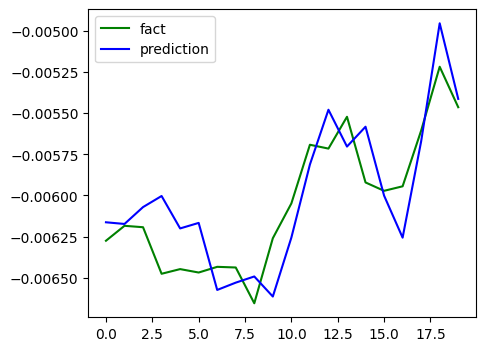

In [172]:
end_index = cs.last_trained_index + 50
fact = []
prediction = []
for i in range(20):
    future_index = end_index + cs.future_len + i
    current_index = end_index=end_index + i
    data, indexes = cs.data_source.get_data(end_index=future_index, count=0)
    fact.append(data[0])
    x, y, _ = cs.create_sequences(
        current_index, cs.seq_len, NUM_LAYERS * context_len)
    prediction.append(nn_prediction(x, y))

plt.plot(fact, label='fact', color='green')
plt.plot(prediction, label='prediction', color='blue')
plt.legend()
plt.show()

In [ ]:
print(model)

Model(
  (model): LSTM(10, 100, num_layers=3, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
)
